### PU Learning

Learning only positives and unlabeled data

In [1]:
import numpy as np
from sklearn import datasets

from pulearn import (
    SoftmaxRegression,
    WeightedUnlabelledSoftmaxRegression,
    HardBootstrappingSoftmaxRegression,
    UnlabelledExponentialLossSoftmaxRegression)
from pulearn.utils import (
    synthesize_pu_labels,
    fit_and_plot
)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Experiment (Synthetic 2D Gaussians)

## Normal setup

In [2]:
X, y = datasets.make_blobs(n_samples=100, n_features=2,
                           centers=[[-3,0], [3,0]])
Y = np.eye(2)[y]

Loss: 0.00389674552456


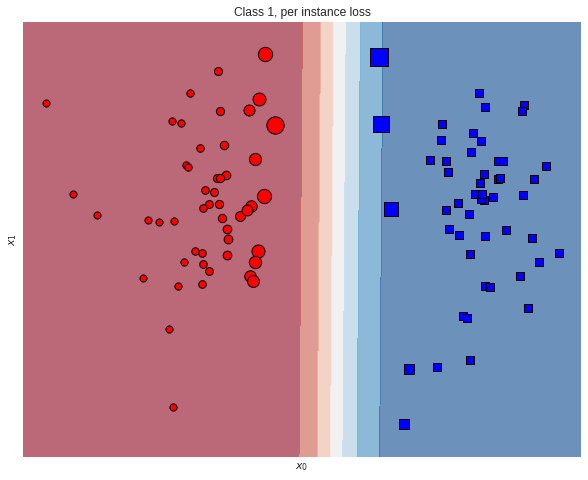

In [3]:
softreg = SoftmaxRegression(batch_size=100,
                            learning_rate=1e-3,
                            alpha=0.,
                            epochs=200,
                            n_classes=2,
                            class_weight=None,
                            random_state=None)
fit_and_plot(X, Y, classifier=softreg, marker_size=["loss"])
print('Loss:', softreg.cost_[-1])

## PU setup

In [4]:
X, y = datasets.make_blobs(n_samples=200, n_features=2,
                           centers=[[-3,0], [3,0]])
Y = np.eye(2)[y]
Y_pu = synthesize_pu_labels(Y, random_state=42, verbose=True)

Positive (pct_missing=0.0): 100  vs. 100
Positive (pct_missing=0.1): 100  vs. 85
Positive (pct_missing=0.2): 100  vs. 81
Positive (pct_missing=0.30000000000000004): 100  vs. 66
Positive (pct_missing=0.4): 100  vs. 57
Positive (pct_missing=0.5): 100  vs. 59
Positive (pct_missing=0.6000000000000001): 100  vs. 46
Positive (pct_missing=0.7000000000000001): 100  vs. 22
Positive (pct_missing=0.8): 100  vs. 17
Positive (pct_missing=0.9): 100  vs. 10
Positive (pct_missing=1.0): 100  vs. 0


Loss: 0.177657839211


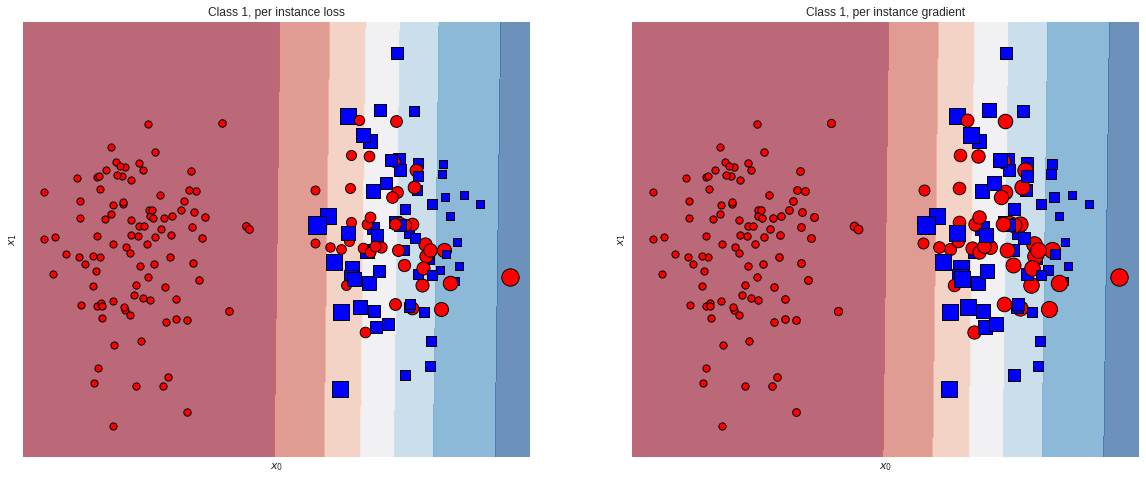

In [5]:
softreg = SoftmaxRegression(batch_size=100,
                            learning_rate=1e-3,
                            alpha=0.,
                            epochs=200,
                            n_classes=2,
                            class_weight=None,
                            random_state=None)
fit_and_plot(X, Y_pu[0.5], classifier=softreg, marker_size=["loss", "gradient"])
print('Loss:', softreg.cost_[-1])

Loss: 0.10858047589


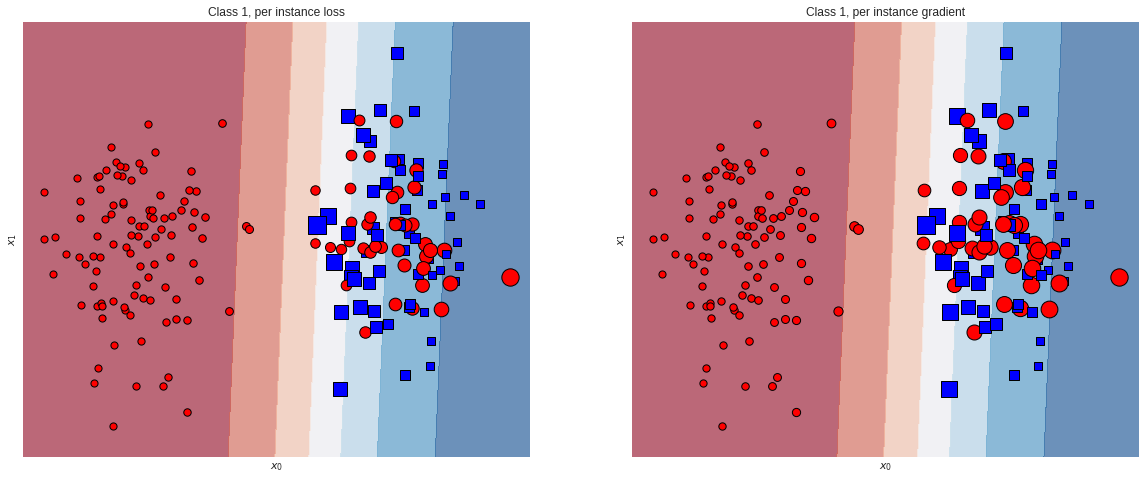

In [6]:
softreg = SoftmaxRegression(n_classes=2,
                            batch_size=100,
                            learning_rate=1e-3,
                            alpha=0.,
                            epochs=200,
                            class_weight="balanced",
                            random_state=None)
fit_and_plot(X, Y_pu[0.5], classifier=softreg, marker_size=["loss", "gradient"])
print('Loss:', softreg.cost_[-1])

Loss: 0.0695264432501


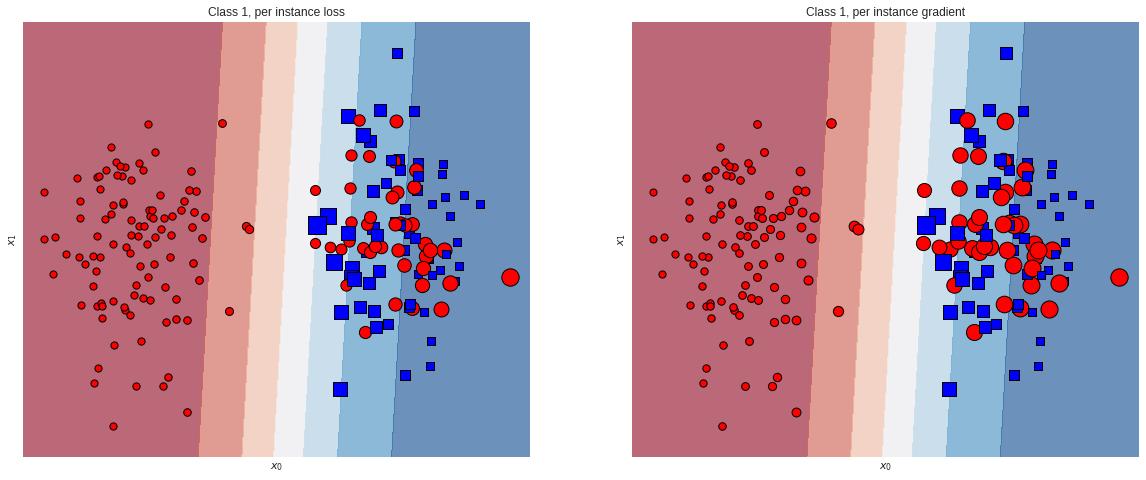

In [7]:
wusr = WeightedUnlabelledSoftmaxRegression(n_classes=2,
                            batch_size=100,
                            learning_rate=1e-3,
                            alpha=0.,
                            epochs=200,
                            class_weight="balanced",
                            unlabelled_weight={0:0.5, 1:1},
                            random_state=None)
fit_and_plot(X, Y_pu[0.5], classifier=wusr, marker_size=["loss", "gradient"])
print('Loss:', wusr.cost_[-1])

Loss 0.074875097765


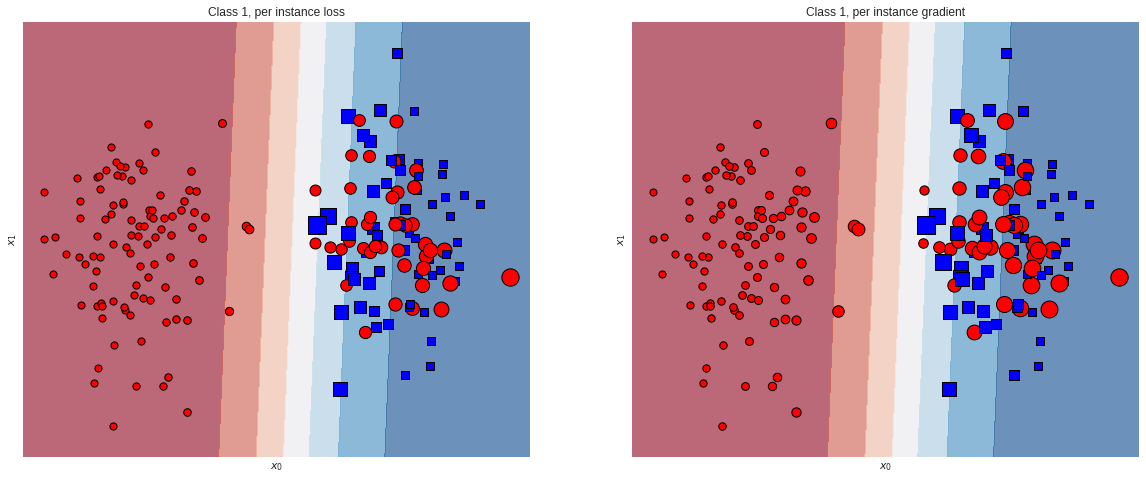

In [8]:
hbsr = HardBootstrappingSoftmaxRegression(n_classes=2,
                            batch_size=100,
                            learning_rate=1e-3,
                            alpha=0.,
                            epochs=200,
                            class_weight="balanced",
                            unlabelled_weight={0:0.5, 1:1},
                            random_state=None)
fit_and_plot(X, Y_pu.get(0.5), classifier=hbsr, marker_size=["loss", "gradient"])
print("Loss", hbsr.cost_[-1])

Loss 0.114423689823


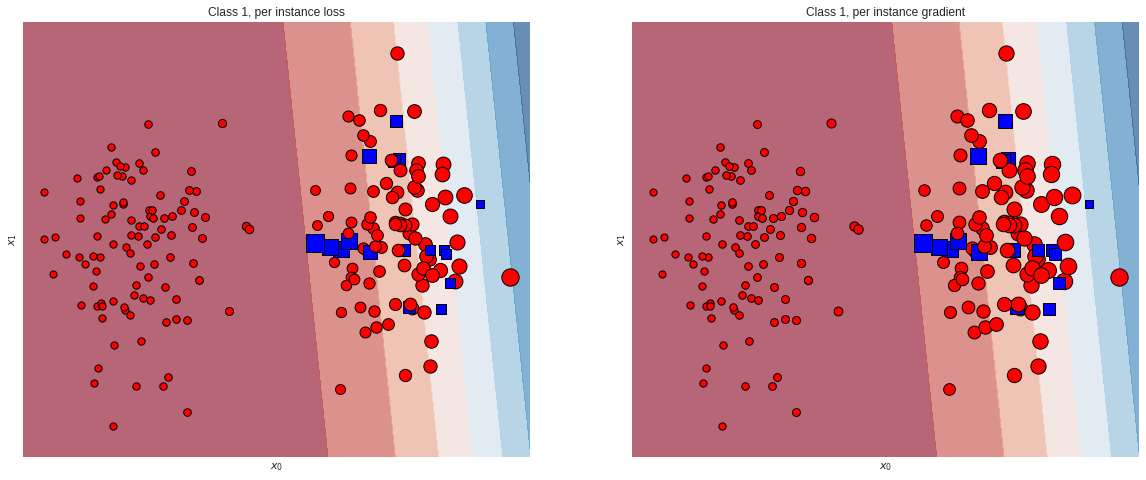

In [10]:
uelsr = UnlabelledExponentialLossSoftmaxRegression(n_classes=2,
                            batch_size=100,
                            learning_rate=1e-3,
                            alpha=0.,
                            epochs=200,
                            class_weight=None,
                            random_state=None)
fit_and_plot(X, Y_pu.get(0.8), classifier=uelsr, marker_size=["loss", "gradient"])
print("Loss", uelsr.cost_[-1])

Loss 0.0219459675426


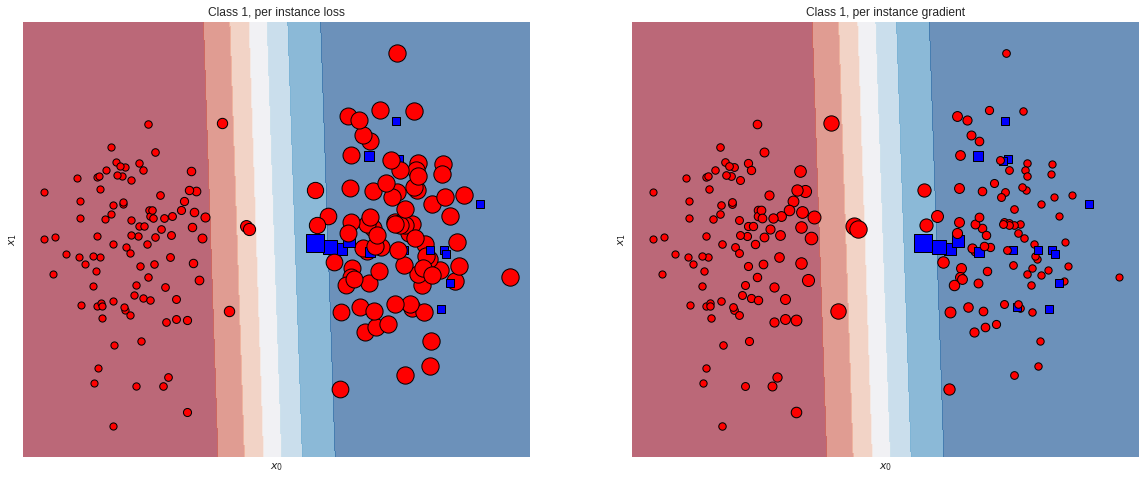

In [9]:
uelsr = UnlabelledExponentialLossSoftmaxRegression(n_classes=2,
                            batch_size=100,
                            learning_rate=1e-3,
                            alpha=0.,
                            epochs=200,
                            class_weight="balanced",
                            random_state=None)
fit_and_plot(X, Y_pu.get(0.8), classifier=uelsr, marker_size=["loss", "gradient"])
print("Loss", uelsr.cost_[-1])

# Depracated experiments

# Weighted unlabeled samples

__Constant__

$ a^{(i)} = a_0 $ (1)

__Probability-dependent__

$ a^{(i)} = (b_0 - a_0)  {p_0^{(i)}}^ r + a_0 $ (2)

where
 + $a^{(i)}$ is the sample weight for the i-th sample (unlabeled)
 + $a_0$ is the class weight for the negative class in Equation (1)
 + $a_0$, $b_0$ is the upper bound and the lower bound of the sample weight for the unlabeled samples in Equation (2)
 + $p_0^{(i)}$ is the predicted negative probablity for the i-th sample (unlabeled)
 + $r$ is a parameter controlling how fast the sample weight changing from 1 to 0 when the predicted negative probability

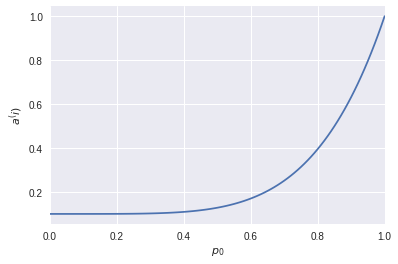

In [3]:
r = 5.
b = 0.1
x = np.arange(0., 1.01, 0.01)
a = (1-b) * np.power(x, r) + b
plt.plot(x, a)
plt.xlim(0,1)
plt.xlabel("$p_0$")
plt.ylabel("$a^({i})$")
plt.show()

In [4]:
class WeightedUSoftmaxRegression(SoftmaxRegression):
    """PU learning."""

    def __init__(self, r_unlabeled=3, a_unlabeled=0., b_unlabeled=1.,
                 eta=0.01, epochs=100,
                 l2=0.0,
                 minibatches=1,
                 n_classes=None,
                 class_weight=None,
                 random_seed=None):
        """Init."""
        super(WeightedUSoftmaxRegression, self).__init__(eta, epochs,
                                                  l2, minibatches,
                                                  n_classes,
                                                  class_weight,
                                                  random_seed)
        self.r_unlabeled = float(r_unlabeled)
        self.a_unlabeled = float(a_unlabeled)
        self.b_unlabeled = float(b_unlabeled)

    def _loss(self, prob, y_enc):
        loss = self._cross_entropy(prob, y_enc)
        loss = np.sum(loss, axis=1)
        if self.a_unlabeled is not None:
            sample_weights = self._sample_weights(prob, y_enc, tiled=False)
            loss = loss * sample_weights
        return loss

    def _diff(self, prob, y_enc):
        diff = prob - y_enc
        if self.a_unlabeled is not None:
            sample_weights = self._sample_weights(prob, y_enc, tiled=True)
            diff = diff * sample_weights
        return diff

    def _sample_weights(self, prob, y_enc, tiled=True):
        sample_weights = np.ones(y_enc.shape)
        unl_idx = np.where(y_enc[:, 0])[0]
        sample_weights[unl_idx, :] = (self.b_unlabeled - self.a_unlabeled)\
            * np.power(prob[unl_idx, :], self.r_unlabeled) \
            + self.a_unlabeled
        if tiled is False:
            return sample_weights[:, 0]
        return sample_weights

## Varying the percentage of positives

In [23]:
import pandas as pd
from sklearn import metrics


distance = 2
X_test, Y_test = get_gaussians(n_samples=1000, pct_positive=0.5,
                               distance=distance, random_seed=42)


classifiers = {
    'softreg': SoftmaxRegression(class_weight=None,
                                 eta=1e-3, l2=1e-5,
                                 epochs=200,
                                 n_classes=2,
                                 unbalanced=True,
                                 random_seed=None),
    'asym_softreg': SoftmaxRegression(class_weight=(0.5, 1),
                                      eta=1e-3, l2=1e-5,
                                      epochs=200,
                                      n_classes=2,
                                      unbalanced=True,
                                      random_seed=None),
    'hardb_softreg': HardBootstrappingSoftmaxRegression(betas=(0.5, 1),
                                       eta=1e-3, l2=1e-5,
                                       epochs=200,
                                       n_classes=2,
                                       unbalanced=True,
                                       random_seed=None),
    'clsdep_softreg': ClassDepLossSoftmaxRegression(eta=1e-3, l2=1e-5,
                                      epochs=200,
                                      n_classes=2,
                                      unbalanced=True,
                                      random_seed=None),
#     'wtdu_softreg': WeightedUSoftmaxRegression(r_unlabeled=5,    
#                                                a_unlabeled=0.,
#                                                b_unlabeled=1. ,
#                                                minibatches=1,
#                                                eta=1e-3, l2=1e-5,
#                                                epochs=200,
#                                                n_classes=2,
#                                                random_seed=None)
}


n_iters = 5
args_list = []
for it in range(n_iters):
    for pct_positive in [0.01, 0.1, 0.2, 0.5, 0.8]:
        X, Y = get_gaussians(n_samples=1000, pct_positive=pct_positive,
                             distance=distance, random_seed=None)
        Y_pus = get_PU_labels(Y, betas=np.arange(0., 1+1e-8, 0.1), random_seed=None)
        for idx in range(len(Y_pus)):
            for name, clsf in classifiers.items():
                args = dict(X=X,
                            Y=Y_pus[idx][1],
                            X_test=X_test,
                            Y_test=Y_test,
                            pct_missing=Y_pus[idx][0],
                            pct_positive=pct_positive,
                            Loss=name,
                            clsf=clsf)
                args_list.append(args)

def fit_classifier(args):
    new_row = {}
    new_row['%missing'] = args['pct_missing']
    new_row['%positive'] = args['pct_positive']
    new_row['Loss'] = args['Loss']
    clsf = args['clsf']
    clsf.fit(args['X'], args['Y'])
    Y_pred = clsf.predict(args['X_test'])
    auc = metrics.roc_auc_score(args['Y_test'], Y_pred)
    new_row['AUC'] = auc
    return new_row

from multiprocessing import Pool
pool = Pool(processes=8)
acc_grid_list = pool.map(fit_classifier, args_list)
acc_grid = pd.DataFrame(acc_grid_list)

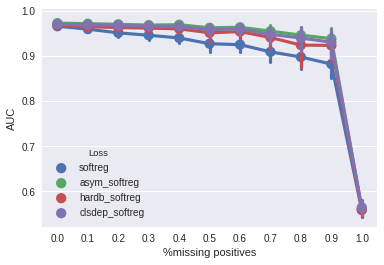

In [24]:
f, ax = plt.subplots(1)

pct_positives = [0.01, 0.1, 0.2, 0.5, 0.8]
# pct_positives = [0.1, 0.2, 0.5]
# pct_positives = [0.8]
# pct_positives = [0.01]

sns.pointplot(x='%missing', y='AUC', hue='Loss', data=acc_grid[acc_grid['%positive'].isin(pct_positives)], ax=ax)
ax.set_xlabel('%missing positives')
ax.set_ylabel('AUC')

### Three Gaussians

Positive (beta=0.0): 750  vs. 750
Positive (beta=0.1): 750  vs. 681
Positive (beta=0.2): 750  vs. 602
Positive (beta=0.30000000000000004): 750  vs. 499
Positive (beta=0.4): 750  vs. 434
Positive (beta=0.5): 750  vs. 371
Positive (beta=0.6000000000000001): 750  vs. 291
Positive (beta=0.7000000000000001): 750  vs. 206
Positive (beta=0.8): 750  vs. 144
Positive (beta=0.9): 750  vs. 96
Positive (beta=1.0): 750  vs. 0


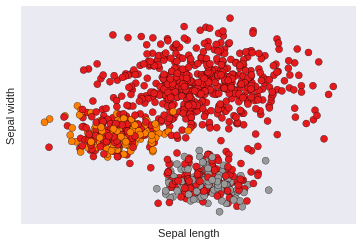

<module 'matplotlib.pyplot' from '/home/jihong/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [26]:
# Number of samples per component
n_samples = 1000
# Percentage of test samples
pct_positive = 0.5
# Distance
distance = 2
# Generate random sample, two components
random_seed = 0     
X, Y = get_3gaussians(n_samples, pct_positive, distance, random_seed=random_seed)
betas = np.arange(0., 1+1e-8, 0.1)
Y_pus = get_PU_labels(Y, betas, random_seed=random_seed)
fit_plot(X, Y_pus[5][1], fit_classifier=False)

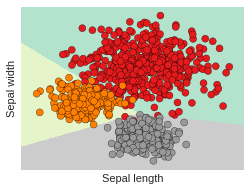

Loss 0.030690128775


In [27]:
np.random.seed(None)
softreg = SoftmaxRegression(eta=1e-2, l2=1e-5,
                            epochs=200,
                            random_seed=None)
fit_plot(X, Y, fit_classifier=softreg)
print("Loss", softreg.cost_[-1])

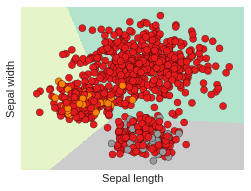

Loss 0.0376099060631


In [28]:
np.random.seed(None)
softreg = SoftmaxRegression(eta=1e-3, l2=1e-5,
                            epochs=200,
                            n_classes=3,
                            unbalanced=True,
                            random_seed=12)
fit_plot(X, Y_pus[8][1], fit_classifier=softreg)
print("Loss", softreg.cost_[-1])

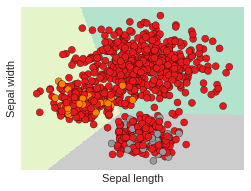

Loss: 0.0246212716369


In [29]:
np.random.seed(None)
clw_softreg = SoftmaxRegression(class_weight=(.5, 1, 1),
                                minibatches=1,
                                eta=1e-3, l2=1e-5,
                                epochs=300,
                                n_classes=3,
                                unbalanced=True,
                                random_seed=None)
fit_plot(X, Y_pus[8][1], fit_classifier=clw_softreg)
print('Loss:', clw_softreg.cost_[-1])

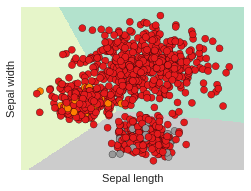

Loss 0.0168144301635


In [32]:
from pu_learning import HardBootstrappingSoftmaxRegression
np.random.seed(None)
hardb_softreg = HardBootstrappingSoftmaxRegression(betas=(0.5, 1, 1),
                                                   eta=1e-3, l2=1e-5,
                                                   epochs=200,
                                                   n_classes=3,
                                                   unbalanced=True,
                                                   random_seed=None)
fit_plot(X, Y_pus[9][1], fit_classifier=hardb_softreg)
print("Loss", hardb_softreg.cost_[-1])

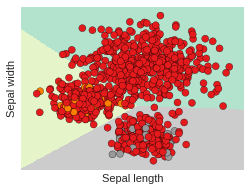

Loss 0.00829833823781


In [33]:
from pu_learning import ClassDepLossSoftmaxRegression
clsdep_softreg = ClassDepLossSoftmaxRegression(eta=1e-2, l2=1e-5,
                                                   epochs=200,
                                                   n_classes=3,
                                                   unbalanced=True,
                                                   random_seed=None)
fit_plot(X, Y_pus[9][1], fit_classifier=clsdep_softreg)
print("Loss", clsdep_softreg.cost_[-1])

In [40]:
import pandas as pd
from sklearn import metrics


distance = 2

X_test, Y_test = get_3gaussians(n_samples=1000, pct_positive=0.66,
                                distance=distance, random_seed=42)


classifiers = {
    'softreg': SoftmaxRegression(class_weight=None,
                                 eta=1e-3, l2=1e-5,
                                 epochs=200,
                                 n_classes=3,
                                 unbalanced=True,
                                 random_seed=None),
    'asym_softreg': SoftmaxRegression(class_weight=(0.5, 1, 1),
                                      eta=1e-3, l2=1e-5,
                                      epochs=200,
                                      n_classes=3,
                                      unbalanced=True,
                                      random_seed=None),
    'hardb_softreg': HardBootstrappingSoftmaxRegression(betas=(0.5, 1, 1),
                                       eta=1e-3, l2=1e-5,
                                       epochs=200,
                                       n_classes=3,
                                       unbalanced=True,
                                       random_seed=None),
    'clsdep_softreg': ClassDepLossSoftmaxRegression(eta=1e-3, l2=1e-5,
                                      epochs=200,
                                      n_classes=3,
                                      unbalanced=True,
                                      random_seed=None)
}

acc_grid = pd.DataFrame(columns=['%missing', 'softreg',
                                 'asym_softreg', 'selasym_softreg', 'hardb_softreg'])
n_iters = 5
args_list = []
for it in range(n_iters):
    for pct_positive in [0.1, 0.2, 0.5, 0.8]:
        X, Y = get_3gaussians(n_samples=500, pct_positive=pct_positive,
                              distance=distance, random_seed=None)
        Y_pus = get_PU_labels(Y, betas=np.arange(0., 1+1e-8, 0.1), random_seed=None)
        for idx in range(len(Y_pus)):
            for name, clsf in classifiers.items():
                args = dict(X=X,
                            Y=Y_pus[idx][1],
                            X_test=X_test,
                            Y_test=Y_test,
                            pct_missing=Y_pus[idx][0],
                            pct_positive=pct_positive,
                            Loss=name,
                            clsf=clsf)
                args_list.append(args)

def fit_classifier(args):
    new_row = {}
    new_row['%missing'] = args['pct_missing']
    new_row['%positive'] = args['pct_positive']
    new_row['Loss'] = args['Loss']
    clsf = args['clsf']
    clsf.fit(args['X'], args['Y'])
    # evaluate
    Y_pred = clsf.predict(args['X_test'])
    Y_test = args['Y_test']
    aucs = []
    for i in range(3):
        y_test = Y_test == i
        y_pred = Y_pred == i
        auc = metrics.roc_auc_score(y_test, y_pred)
        aucs.append(auc)
    new_row['AUC'] = np.mean(aucs)
    return new_row

from multiprocessing import Pool
pool = Pool(processes=8)
acc_grid_list = pool.map(fit_classifier, args_list)
acc_grid = pd.DataFrame(acc_grid_list)

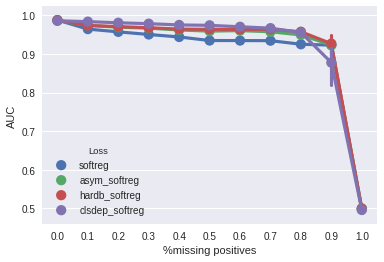

In [41]:
import seaborn as sns
f, ax = plt.subplots(1)

pct_positives = [0.1, 0.2, 0.5, 0.8]
pct_positives = [0.8]
sns.pointplot(x='%missing', y='AUC', hue='Loss', data=acc_grid[acc_grid['%positive'].isin(pct_positives)], ax=ax)
ax.set_xlabel('%missing positives')
ax.set_ylabel('AUC')